In [1]:
"""
Exp01B: Sub-sample Stability (Time Robustness)

Goal:
- Validate whether the MA window robustness observed in Exp01 holds.

Fixed:
- Asset: SPY
- Execution: next-bar
- Risk: none (baseline)


Sweep:
- Time slice (subsample)
- MA_WINDOW
"""

'\nExp01B: Sub-sample Stability (Time Robustness)\n\nGoal:\n- Validate whether the MA window robustness observed in Exp01 holds.\n\nFixed:\n- Asset: SPY\n- Execution: next-bar\n- Cost: cfg.COST_RATE\n- Risk: none (baseline)\n\n\nSweep:\n- Time slice (subsample)\n- MA_WINDOW\n'

In [2]:
import os
os.chdir("..")
print(os.getcwd())

/Users/kim/Desktop/Quant-Research


In [3]:
from copy import deepcopy
import pandas as pd

from config import Config
from runner import run

In [4]:
from config import Config
cfg = Config()   # baseline config
print(cfg)

Config(DATA_PATH='data/raw/SPY_2015_2025.csv', PRICE_COL='Close', MA_WINDOW=20, LONG_ONLY=True, COST_RATE=0.001, START=None, END=None)


## ① 第一层（必做）：宏观结构阶段切分 （Stage-based subsample stability）
👉 这个切法的研究意义是：

每一段 市场结构完全不同

如果 qualitative behavior 一致
→ 信号是真的“结构性”，不是吃某种行情

In [5]:
"""
Exp01B (Stage-level): Sub-sample Stability across Market Regimes (2015–2025)

Goal:
- Test whether the MA baseline exhibits consistent qualitative behavior
  across structurally different market regimes.

Fixed:
- Asset: SPY
- Execution: next-bar
- Cost: cfg.COST_RATE
- Risk: none (baseline)
- MA_WINDOW: fixed (chosen from Exp01 plateau)

Variable:
- Time subsample (subsample)
"""

'\nExp01B (Stage-level): Sub-sample Stability across Market Regimes (2015–2025)\n\nGoal:\n- Test whether the MA baseline exhibits consistent qualitative behavior\n  across structurally different market regimes.\n\nFixed:\n- Asset: SPY\n- Execution: next-bar\n- Cost: cfg.COST_RATE\n- Risk: none (baseline)\n- MA_WINDOW: fixed (chosen from Exp01 plateau)\n\nVariable:\n- Time subsample (subsample)\n'

In [6]:
subsamples = {
    "2015-2017": ("2015-01-02", "2017-12-29"),   # post-GFC recovery / sideways
    "2018-2019": ("2018-01-02", "2019-12-31"),   # vol spikes + pre-covid
    "2020-2021": ("2020-01-02", "2021-12-31"),   # covid crash + QE bull
    "2022":      ("2022-01-03", "2022-12-30"),   # rate-hike bear
    "2023-2025": ("2023-01-03", "2025-01-03"),   # recent regime
    "full":      ("2015-01-02", "2025-01-03"),
}

In [8]:
from dataclasses import replace
cfg_base = Config()
cfg_base = replace(cfg, MA_WINDOW=80)   # 选一个 Exp01 plateau 的中心，此处选80

In [10]:
rows = []

for name, (start, end) in subsamples.items():
    cfg = deepcopy(cfg_base)
    cfg = replace(cfg, START = start, END = end) 

    _, s = run(cfg)

    s["subsample"] = name
    s["START"] = start
    s["END"] = end
    s["MA_WINDOW"] = cfg.MA_WINDOW

    rows.append(s)

exp01b_stage = pd.DataFrame(rows)
exp01b_stage


/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs,subsample,START,END,MA_WINDOW
0,0.057110,-0.141116,0.693221,30.0,655,2015-2017,2015-01-02,2017-12-29,100
1,0.017284,-0.163998,0.230351,22.0,403,2018-2019,2018-01-02,2019-12-31,100
2,0.307099,-0.095408,1.839638,10.0,405,2020-2021,2020-01-02,2021-12-31,100
3,-0.147752,-0.112498,-1.301395,10.0,151,2022,2022-01-03,2022-12-30,100
4,0.221047,-0.084972,1.833115,4.0,402,2023-2025,2023-01-03,2025-01-03,100
5,0.074117,-0.196409,0.692780,100.0,2416,full,2015-01-02,2025-01-03,100


In [11]:
exp01b_stage.set_index("subsample")[[
    "Sharpe",
    "Annual Return",
    "Max Drawdown",
    "Total Turnover"
]]

,Sharpe,Annual Return,Max Drawdown,Total Turnover
subsample,,,,
2015-2017,0.693221,0.057110,-0.141116,30.0
2018-2019,0.230351,0.017284,-0.163998,22.0
2020-2021,1.839638,0.307099,-0.095408,10.0
2022,-1.301395,-0.147752,-0.112498,10.0
2023-2025,1.833115,0.221047,-0.084972,4.0
full,0.692780,0.074117,-0.196409,100.0


<Axes: title={'center': 'Sharpe by Market Stage (MA=100)'}, xlabel='subsample'>

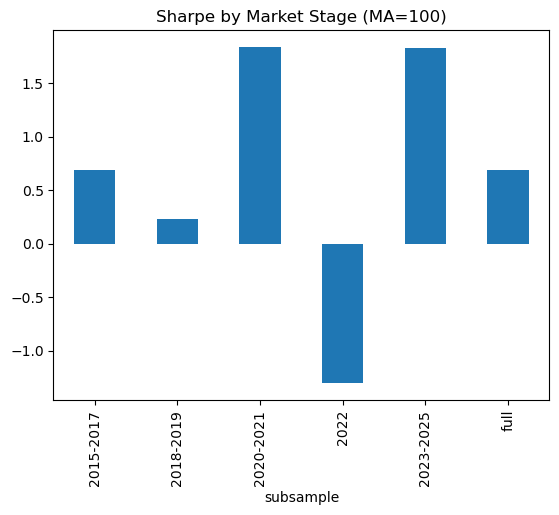

In [12]:
exp01b_stage.set_index("subsample")["Sharpe"].plot(
    kind="bar", title=f"Sharpe by Market Stage (MA={cfg_base.MA_WINDOW})"
)

## ② 第二层（推荐）：固定 window，看不同阶段表现 (同上)

先不 sweep window，固定一个 Exp01 里选的“代表性 window”,（比如 MA=50 或 MA=100）。

👉 这个切法的研究意义是：

每一段 市场结构完全不同

如果 qualitative behavior 一致
→ 信号是真的“结构性”，不是吃某种行情

In [13]:
from dataclasses import replace
cfg_base = Config()
cfg_base = replace(cfg, MA_WINDOW=60)   # 选60，以和上面区分，同时验证上面的结论不是因为window=80而偶然产生的

In [14]:
rows = []

for name, (start, end) in subsamples.items():
    cfg = deepcopy(cfg_base)
    cfg = replace(cfg, START = start, END = end) 

    _, s = run(cfg)

    s["subsample"] = name
    s["START"] = start
    s["END"] = end
    s["MA_WINDOW"] = cfg.MA_WINDOW

    rows.append(s)

exp01b_stage = pd.DataFrame(rows)
exp01b_stage

/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs,subsample,START,END,MA_WINDOW
0,0.017785,-0.148727,0.255848,54.0,695,2015-2017,2015-01-02,2017-12-29,60
1,0.011958,-0.165032,0.176316,27.0,443,2018-2019,2018-01-02,2019-12-31,60
2,0.210537,-0.112003,1.396185,19.0,445,2020-2021,2020-01-02,2021-12-31,60
3,-0.227142,-0.177404,-2.038288,20.0,191,2022,2022-01-03,2022-12-30,60
4,0.190534,-0.066318,1.681053,19.0,442,2023-2025,2023-01-03,2025-01-03,60
5,0.040825,-0.244330,0.423202,165.0,2456,full,2015-01-02,2025-01-03,60


In [15]:
exp01b_stage.set_index("subsample")[[
    "Sharpe",
    "Annual Return",
    "Max Drawdown",
    "Total Turnover"
]]

,Sharpe,Annual Return,Max Drawdown,Total Turnover
subsample,,,,
2015-2017,0.255848,0.017785,-0.148727,54.0
2018-2019,0.176316,0.011958,-0.165032,27.0
2020-2021,1.396185,0.210537,-0.112003,19.0
2022,-2.038288,-0.227142,-0.177404,20.0
2023-2025,1.681053,0.190534,-0.066318,19.0
full,0.423202,0.040825,-0.244330,165.0


<Axes: title={'center': 'Sharpe by Market Stage (MA=60)'}, xlabel='subsample'>

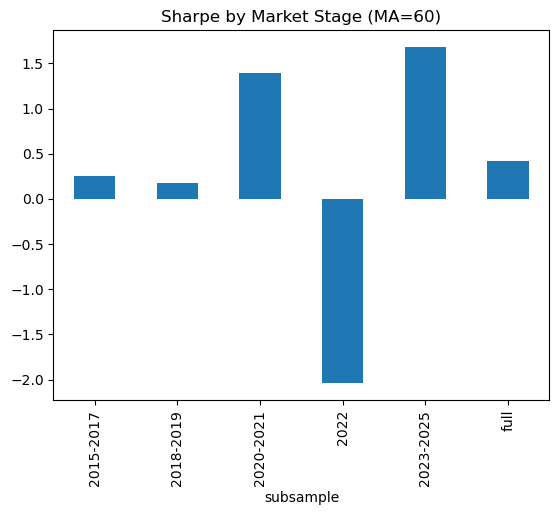

In [16]:
exp01b_stage.set_index("subsample")["Sharpe"].plot(
    kind="bar", title=f"Sharpe by Market Stage (MA={cfg_base.MA_WINDOW})"
)

## ③ 第三层（加分项）：每个阶段内是否仍然存在 plateau

小范围 sweep（不用太密）

In [22]:
# Sweep: sub-sample + MA window 
from dataclasses import replace
from config import Config

cfg = Config()   # baseline config


windows = [50, 60, 80, 100]
rows = []


base_cfg = Config()

for name, (start, end) in subsamples.items():
    for w in windows:
        cfg = replace(
            base_cfg,
            START=start,
            END=end,
            MA_WINDOW=w,
        )

        _, s = run(cfg)

        s["subsample"] = name
        s["MA_WINDOW"] = w
        rows.append(s)


exp01b = pd.DataFrame(rows) # 汇总成一个 实验结果表（experiment table）

exp01b

/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs,subsample,MA_WINDOW
0,-0.006290,-0.185188,-0.041875,70.0,705,2015-2017,50
1,0.017785,-0.148727,0.255848,54.0,695,2015-2017,60
2,0.066957,-0.118435,0.806350,26.0,675,2015-2017,80
3,0.057110,-0.141116,0.693221,30.0,655,2015-2017,100
4,0.045989,-0.092255,0.571158,22.0,453,2018-2019,50
5,0.011958,-0.165032,0.176316,27.0,443,2018-2019,60
6,0.040937,-0.149217,0.497173,21.0,423,2018-2019,80
7,0.017284,-0.163998,0.230351,22.0,403,2018-2019,100
8,0.188096,-0.104700,1.293851,27.0,455,2020-2021,50
9,0.210537,-0.112003,1.396185,19.0,445,2020-2021,60


<Axes: title={'center': 'Exp01C | Sharpe vs MA Window (by Subsample)'}, xlabel='MA_WINDOW'>

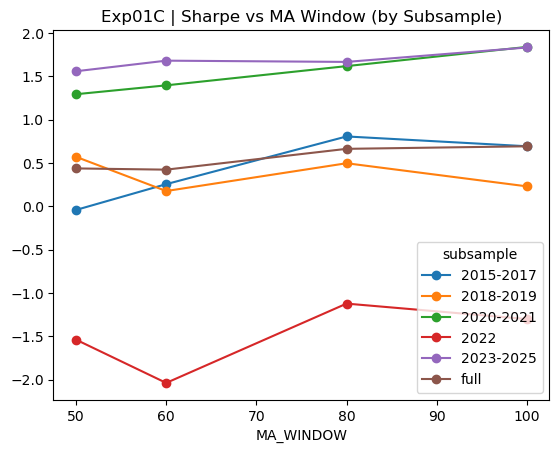

In [23]:
pivot_sharpe = exp01b.pivot(
    index="MA_WINDOW",
    columns="subsample",
    values="Sharpe"
)

pivot_sharpe.plot(
    title="Exp01B | Sharpe vs MA Window (by Subsample)",
    marker="o"
)